In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths

# File path and name
file_path = '/Users/muntasirmahmud/Library/CloudStorage/OneDrive-UMBC/4. SciGlob/Panndora_456/Lab_pandora/25_Apr 25_pandora157/Pandora157s1_GreenbeltMD_20250328_L0.txt'

base_name = os.path.basename(file_path)

# Read the entire file
with open(file_path, 'r', encoding='latin1') as file:
    lines = file.readlines()

# Skip the initial 89 rows
data_lines = lines[44:]

# Process each line to split into rows and columns
data_list = []
for line in data_lines:
    # Strip the newline character and split by tabs
    rows = line.strip().split('\t')
    for row in rows:
        # Split each row by spaces
        columns = row.split()
        data_list.append(columns)

# Convert the list of lists into a DataFrame
data1 = pd.DataFrame(data_list)

# Convert the necessary columns to numeric before saving
data1.iloc[:, 2:4127] = data1.iloc[:, 2:4127].apply(pd.to_numeric, errors='coerce')


sq_l0 shape: (198, 2048), ulnf shape: (198, 2048)


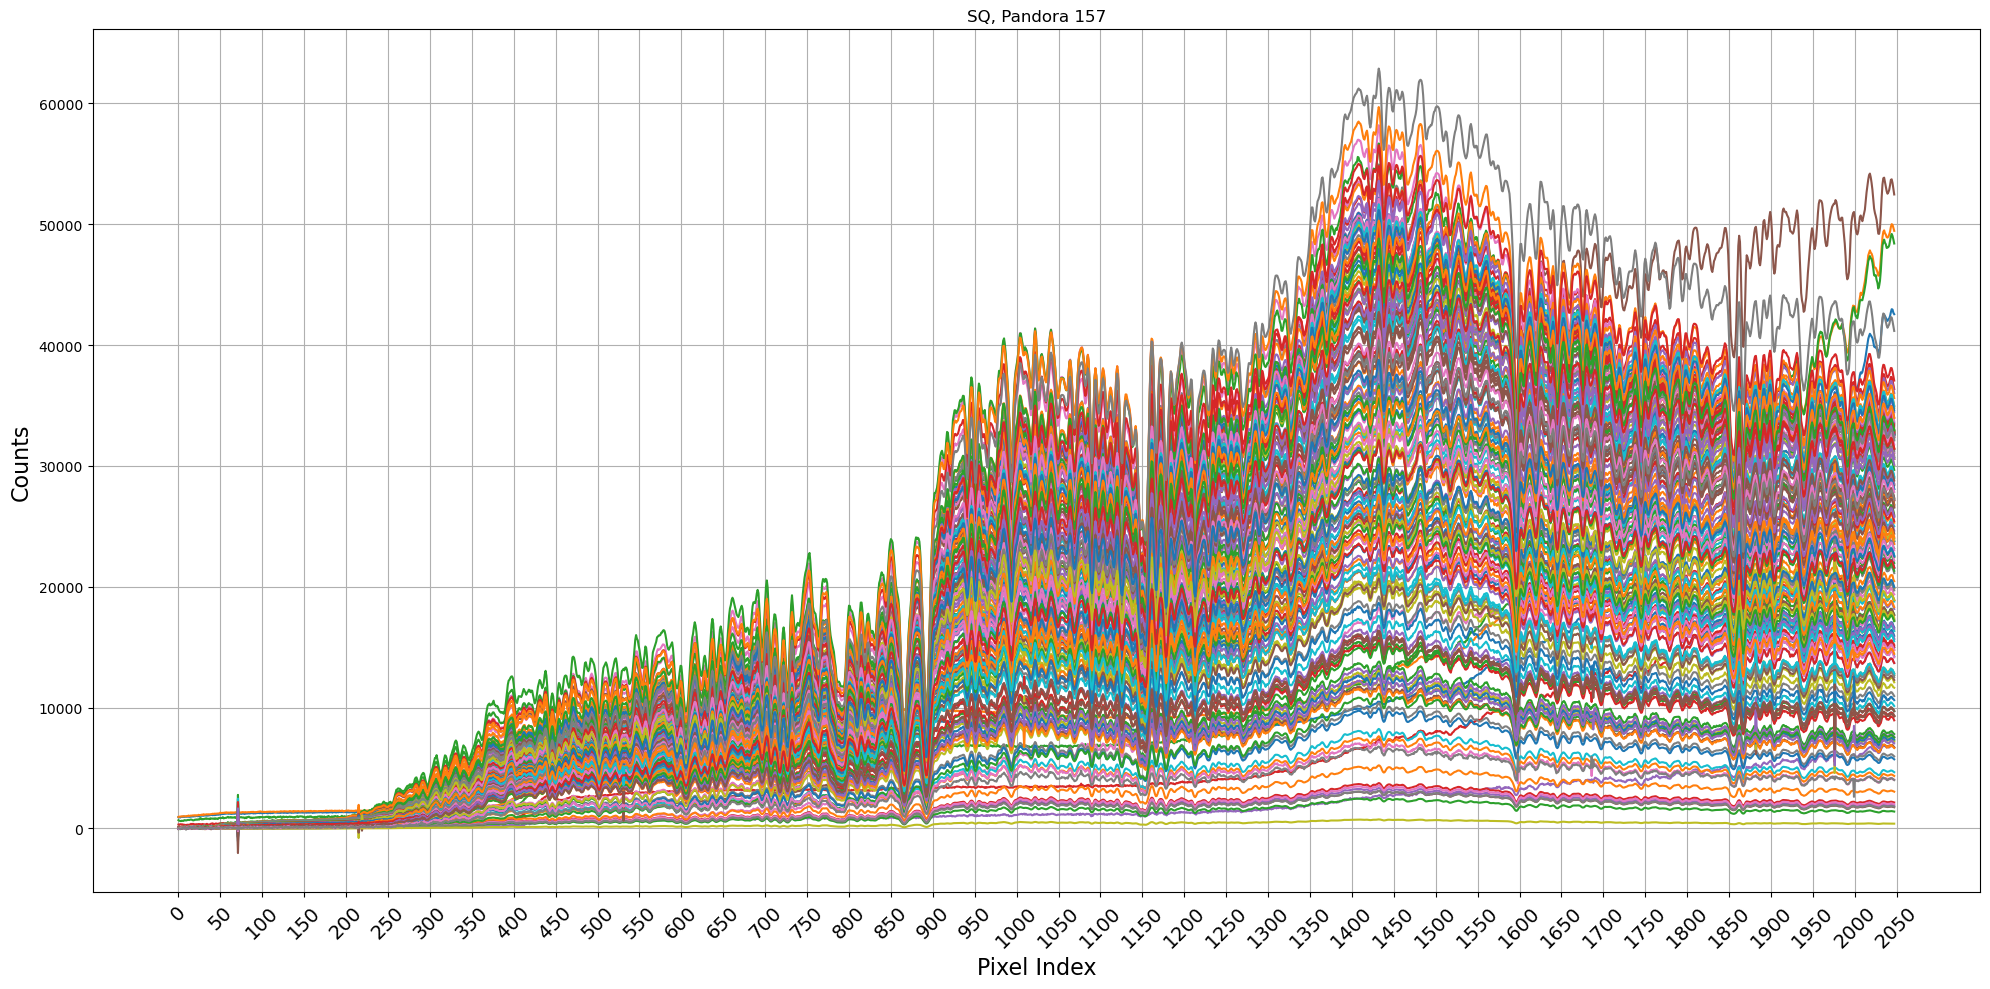

In [3]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Convert routine count to numeric
data1[2] = pd.to_numeric(data1[2], errors='coerce')

R = 'SQ'  # Routine name
is_SQ = data1[0] == R
is_bc = (data1[8] < 3) & (data1[9] == 7) & (data1[10] < 1)
is_dc = (data1[8] < 3) & (data1[9] == 3) & (data1[10] < 1)

SQ_bc_full = data1[is_SQ & is_bc].copy()
SQ_dc_full = data1[is_SQ & is_dc].copy()

# Add routine and scale columns
SQ_bc_full['routine'] = SQ_bc_full[2].astype(float)
SQ_dc_full['routine'] = SQ_dc_full[2].astype(float)
SQ_bc_full['scale'] = SQ_bc_full[22].astype(float)
SQ_dc_full['scale'] = SQ_dc_full[22].astype(float)

# Index dark rows by routine number
grouped_dc = SQ_dc_full.set_index('routine')

# Initialize results
matched_sq = []
matched_unc = []
routine_ids = []
routine_times = []

# Loop through each bright row individually (548 rows)
for idx, row in SQ_bc_full.iterrows():
    routine = row['routine']
    
    # Get and scale bright spectrum
    bc_scaled = row.iloc[24:2072].astype(float) / row['scale']
    bc_unc_scaled = row.iloc[2076:4124].astype(float) / row['scale']

    # Try to subtract matched dark
    if routine in grouped_dc.index:
        dark_row = grouped_dc.loc[routine]
        if isinstance(dark_row, pd.DataFrame):
            dark_row = dark_row.iloc[0]
        dc_scaled = dark_row.iloc[24:2072].astype(float) / dark_row['scale']
        dc_unc_scaled = dark_row.iloc[2076:4124].astype(float) / dark_row['scale']
        
        sq = bc_scaled.values - dc_scaled.values
        unc = bc_unc_scaled.values - dc_unc_scaled.values
    else:
        # No matching dark row — keep bright as is
        sq = bc_scaled.values
        unc = bc_unc_scaled.values

    # Store everything
    matched_sq.append(sq)
    matched_unc.append(unc)
    routine_ids.append(routine)

    # Time extraction
    time_str = row[1]
    try:
        dt_obj = datetime.strptime(time_str[:15], "%Y%m%dT%H%M%S")
        dt_adjusted = dt_obj - timedelta(hours=4)
        hhmm = dt_adjusted.strftime("%H%M")
    except Exception:
        hhmm = '0000'
    routine_times.append(hhmm)

# Convert to arrays
sq_l0 = np.array(matched_sq)
ulnf = np.array(matched_unc)
sq_l0_df = pd.DataFrame(sq_l0, index=routine_ids)

# Sanity check
print(f"sq_l0 shape: {sq_l0.shape}, ulnf shape: {ulnf.shape}")

# Plot
plt.figure(figsize=(20, 10))
for i in range(len(sq_l0)):
    plt.plot(sq_l0[i])
plt.title(f"{R}, Pandora 157")
plt.xlabel("Pixel Index", fontsize=16)
plt.ylabel("Counts", fontsize=16)
plt.xticks(np.arange(0, 2051, 50), rotation=45, fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
import re

# Load calibration file for dispersion and wavelength ===
with open('/Users/muntasirmahmud/Library/CloudStorage/OneDrive-UMBC/4. SciGlob/Panndora_456/Lab_pandora/25_Apr 25_pandora157/Pandora157s1_CF_session8.txt', 'r') as f:
    lines = f.readlines()

dispersion_coeffs = []
loref = None

for line in lines:
    if "Dispersion polynomial" in line:
        dispersion_coeffs = list(map(float, re.findall(r'[-+]?\d*\.\d+e[+-]?\d+', line)))
    if "Reference wavelength for wavelength change retrieval" in line:
        loref = float(re.findall(r'[-+]?\d*\.\d+', line)[0])

# Compute pixel-wise wavelengths from dispersion ===
npix = 2048
pix = np.arange(1, npix + 1)
pixs = 3.46 * ((pix / npix) - 0.5)
lo = np.polyval(dispersion_coeffs, pixs)

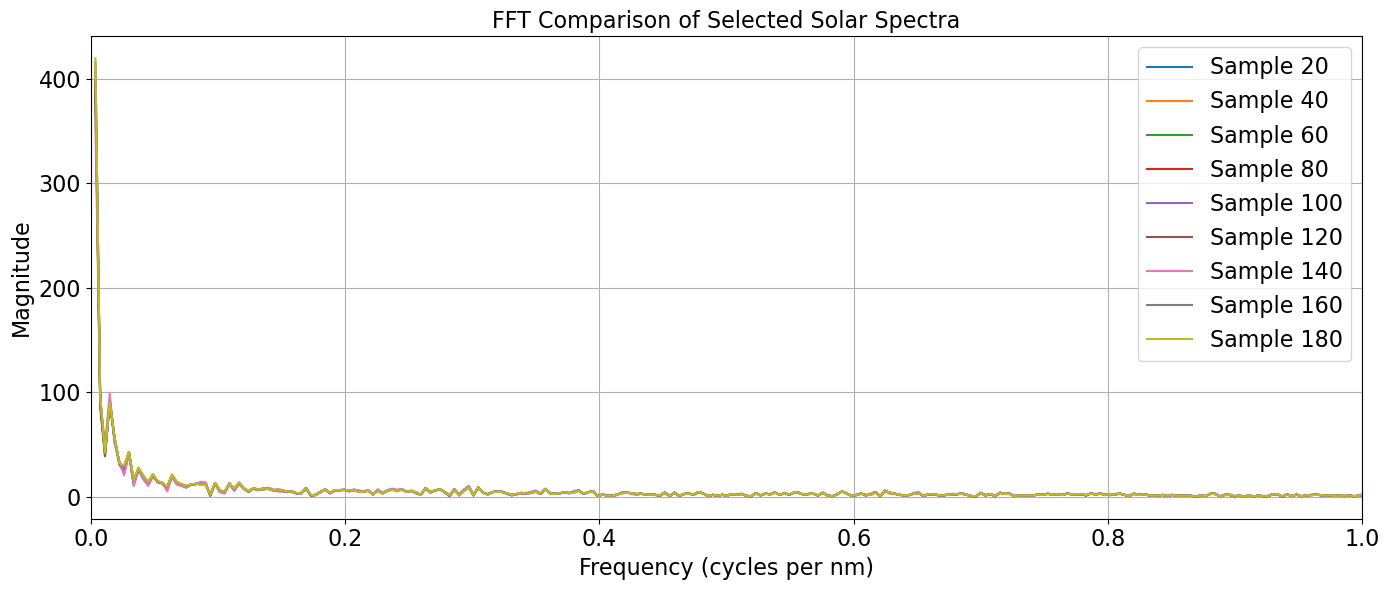

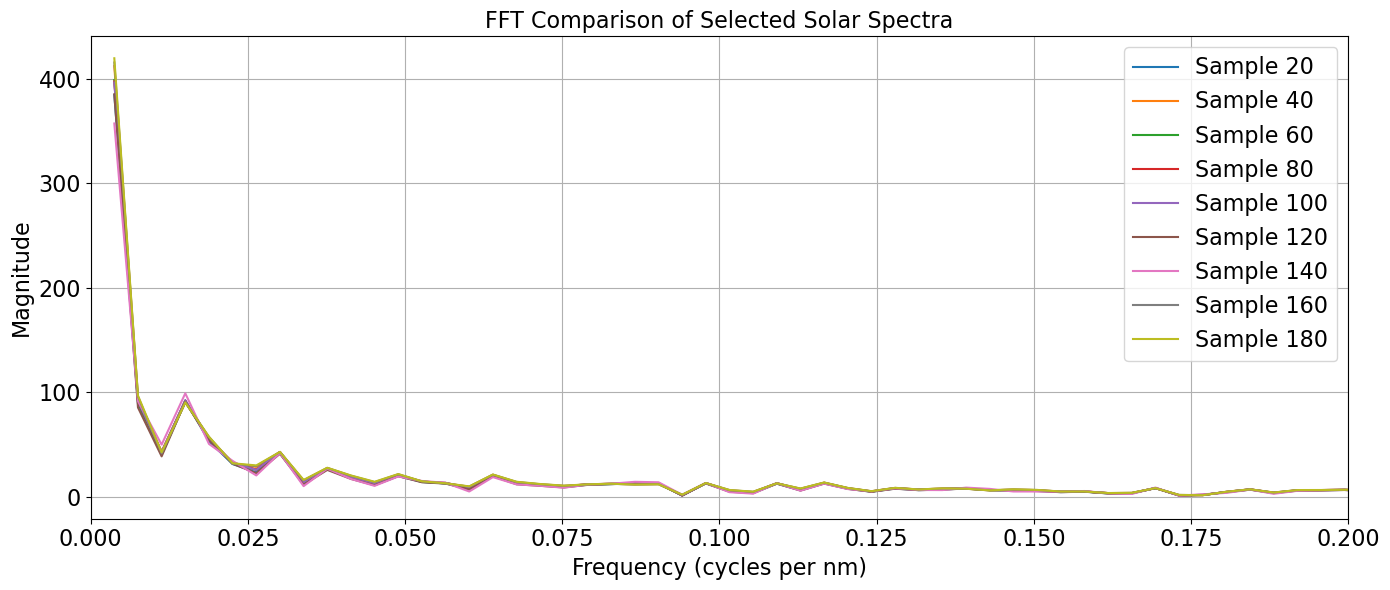

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Normalize each spectrum
for i in range(len(sq_l0)):
    sq_l0[i] = sq_l0[i] / max(sq_l0[i])

# Wavelength spacing in nm
delta_lambda = np.mean(np.diff(lo))

# Frequency axis
fft_freq = np.fft.fftfreq(sq_l0.shape[1], d=delta_lambda)
positive_freq_idx = fft_freq > 0

# Select indices of spectra to compare
# selected_indices = [0, 25, 50, 100, 150]
# selected_indices = [0,1,2,50,51,52]
selected_indices = [20, 40, 60, 80, 100, 120, 140, 160, 180]

plt.figure(figsize=(14, 6))
# Loop through selected measurements
for i in selected_indices:
    signal = sq_l0[i]
    fft_result = np.fft.fft(signal)
    fft_magnitude = np.abs(fft_result)
    
    plt.plot(fft_freq[positive_freq_idx], fft_magnitude[positive_freq_idx], label=f"Sample {i}")

plt.title("FFT Comparison of Selected Solar Spectra", fontsize=16)
plt.xlabel("Frequency (cycles per nm)", fontsize=16)
plt.ylabel("Magnitude", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(0,1)
# plt.ylim(0,100)
plt.legend(fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
# Loop through selected measurements
for i in selected_indices:
    signal = sq_l0[i]
    fft_result = np.fft.fft(signal)
    fft_magnitude = np.abs(fft_result)
    
    plt.plot(fft_freq[positive_freq_idx], fft_magnitude[positive_freq_idx], label=f"Sample {i}")

plt.title("FFT Comparison of Selected Solar Spectra", fontsize=16)
plt.xlabel("Frequency (cycles per nm)", fontsize=16)
plt.ylabel("Magnitude", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(0,0.2)
# plt.ylim(0,100)
plt.legend(fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

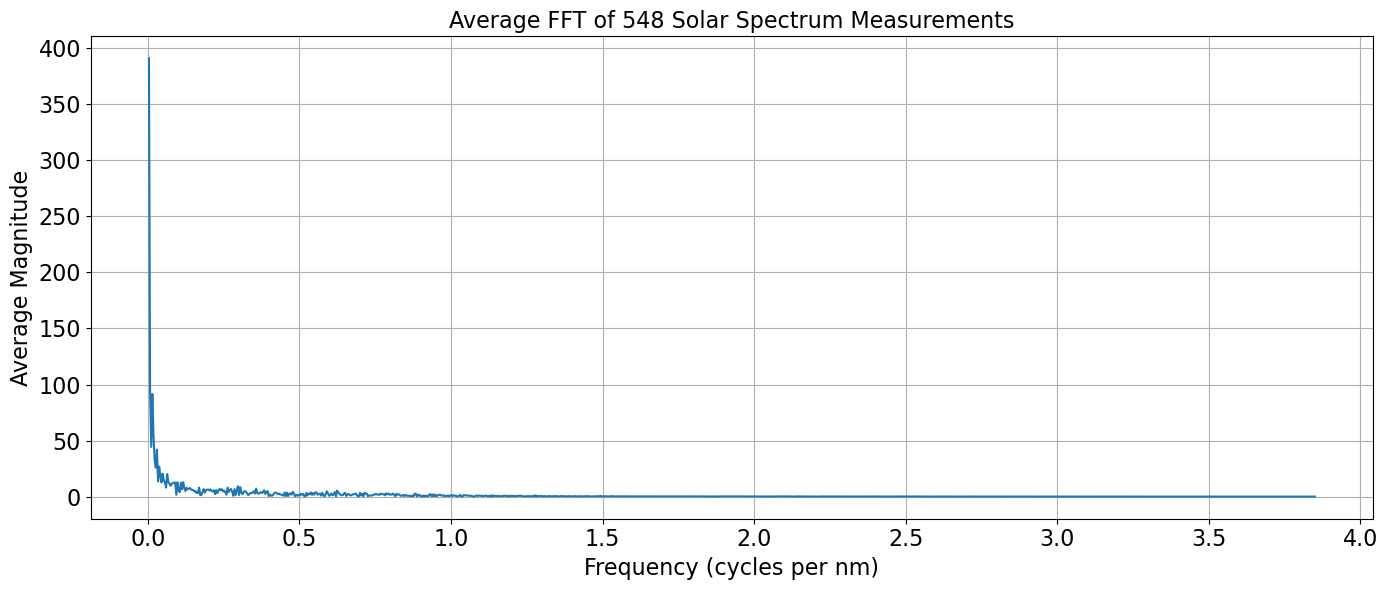

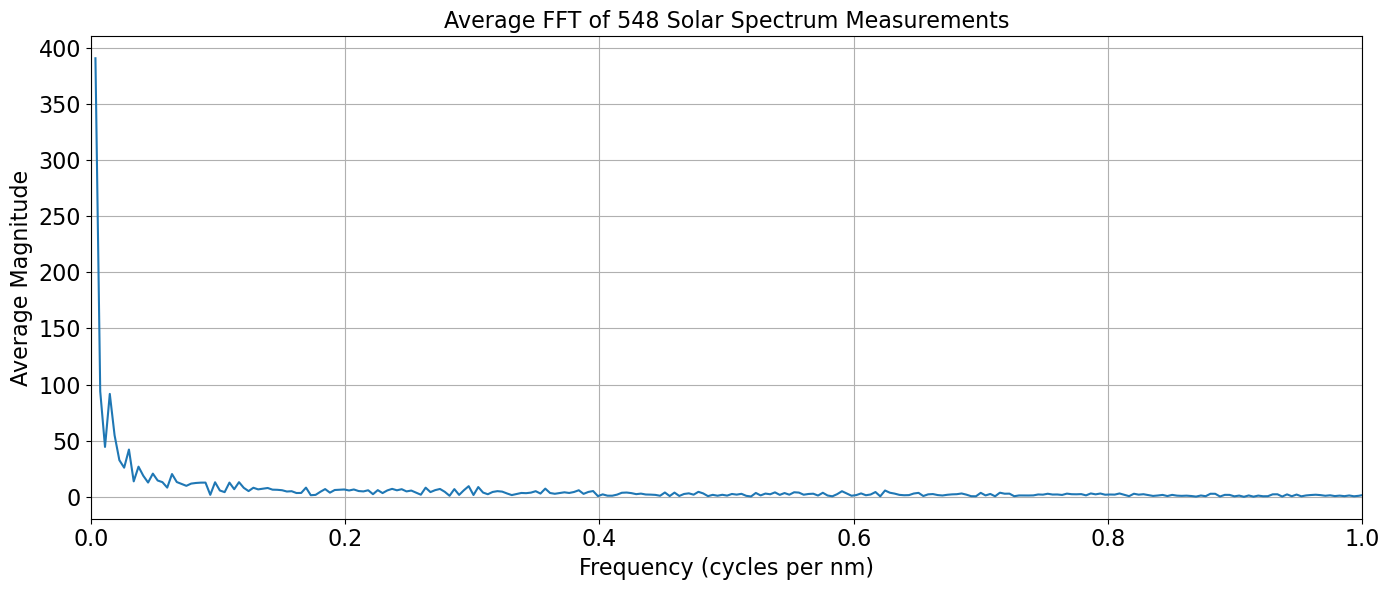

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Setup
n_samples, n_pixels = sq_l0.shape
delta_lambda = np.mean(np.diff(lo))  # wavelength spacing in nm

# Step 2: Frequency axis for plotting (cycles per nm)
fft_freq = np.fft.fftfreq(n_pixels, d=delta_lambda)
positive_freq_idx = fft_freq > 0

# Step 3: Initialize sum for averaging
fft_magnitude_sum = np.zeros(n_pixels)

# Step 4: Compute FFT for each row and accumulate magnitude
for i in range(n_samples):
    signal = sq_l0[i]
    fft_result = np.fft.fft(signal)
    fft_magnitude = np.abs(fft_result)
    fft_magnitude_sum += fft_magnitude

# Step 5: Average
fft_magnitude_avg = fft_magnitude_sum / n_samples

# Step 6: Plot only the positive frequencies
plt.figure(figsize=(14, 6))
plt.plot(fft_freq[positive_freq_idx], fft_magnitude_avg[positive_freq_idx])
plt.title("Average FFT of 548 Solar Spectrum Measurements", fontsize=16)
plt.xlabel("Frequency (cycles per nm)", fontsize=16)
plt.ylabel("Average Magnitude", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(fft_freq[positive_freq_idx], fft_magnitude_avg[positive_freq_idx])
plt.title("Average FFT of 548 Solar Spectrum Measurements", fontsize=16)
plt.xlabel("Frequency (cycles per nm)", fontsize=16)
plt.ylabel("Average Magnitude", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(0,1)
# plt.ylim(0,500)
plt.grid(True)
plt.tight_layout()
plt.show()


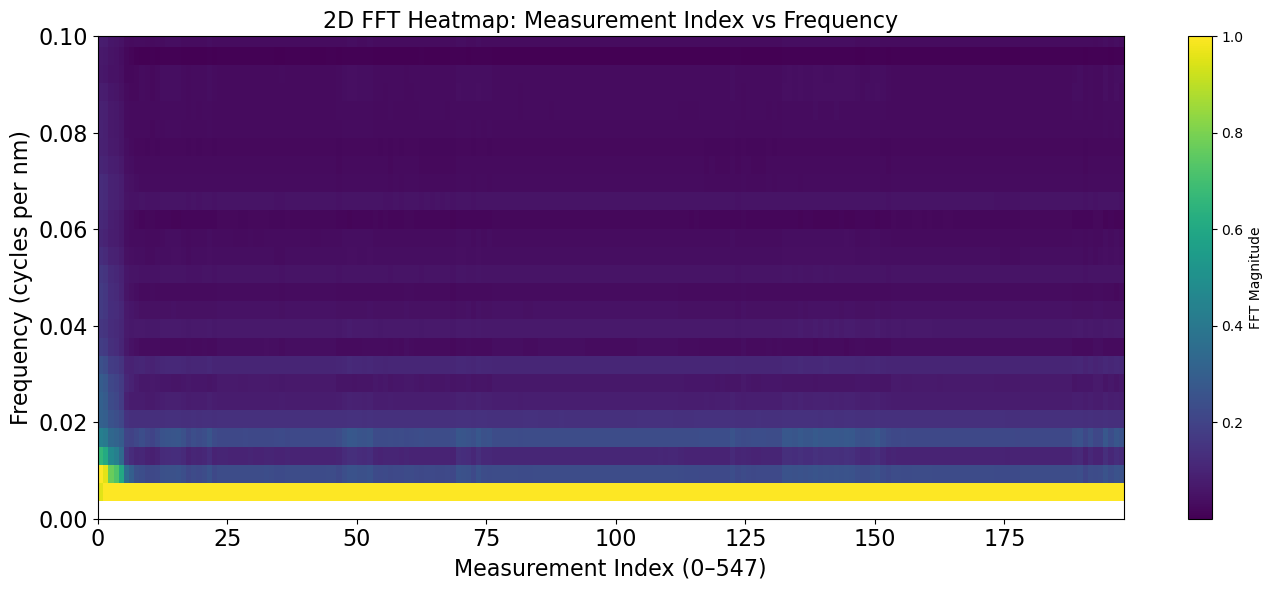

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n_measurements, n_pixels = sq_l0.shape
delta_lambda = np.mean(np.diff(lo))  # nm spacing
fft_freq = np.fft.fftfreq(n_pixels, d=delta_lambda)
positive_freq_idx = fft_freq > 0
fft_freq_pos = fft_freq[positive_freq_idx]

# Compute normalized FFT magnitude for each measurement
fft_matrix = []
for i in range(n_measurements):
    signal = sq_l0[i]  # already normalized per your note
    fft_result = np.fft.fft(signal)
    fft_magnitude = np.abs(fft_result)[positive_freq_idx]
    
    # Normalize FFT by max (optional for shape-only comparison)
    fft_magnitude /= np.max(fft_magnitude)
    fft_matrix.append(fft_magnitude)

fft_matrix = np.array(fft_matrix).T  # shape: (frequencies, measurements)

# Apply log scale for contrast (optional toggle)
use_log_scale = False #True 
if use_log_scale:
    fft_matrix = np.log1p(fft_matrix)  # log(1 + x) for better visibility

# Plot heatmap: freq on Y, measurement index on X
plt.figure(figsize=(14, 6))
plt.imshow(fft_matrix, aspect='auto', cmap='viridis',
           extent=[0, n_measurements, fft_freq_pos[0], fft_freq_pos[-1]],
           origin='lower')
plt.colorbar(label='log(FFT Magnitude)' if use_log_scale else 'FFT Magnitude')
plt.title("2D FFT Heatmap: Measurement Index vs Frequency", fontsize=16)
plt.xlabel("Measurement Index (0–547)", fontsize=16)
plt.ylabel("Frequency (cycles per nm)", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0,0.1)
plt.tight_layout()
plt.show()
